See also final script in ../scripts/freezing_level.py

In [1]:
%matplotlib inline

In [2]:
import sys
import os
aps_path = os.path.dirname(os.path.abspath("."))
if aps_path not in sys.path:
    sys.path.append(aps_path)
print(aps_path, sys.path)

D:\Dev\APS\aps ['', 'C:\\Anaconda3\\python36.zip', 'C:\\Anaconda3\\DLLs', 'C:\\Anaconda3\\lib', 'C:\\Anaconda3', 'C:\\Anaconda3\\lib\\site-packages', 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.1-py3.6.egg', 'C:\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kmu\\.ipython', 'D:\\Dev\\APS\\aps']


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="dark")
import aps_io.get_arome as ga
from load_region import load_region, clip_region

In [4]:
hour_range = [24, 48]
ncfile = r"\\hdata\grid\metdata\prognosis\meps\det\archive\2019\meps_det_extracted_1km_20190307T00Z.nc"
#jd, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm"], time_period=[6, 25])
times, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm", "altitude_of_isoTprimW_equal_0"], time_period=hour_range)

### DIMENSIONS ###
OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 67
), ('height0', <class 'netCDF4._netCDF4.Dimension'>: name = 'height0', size = 1
), ('isotherm_0C_level', <class 'netCDF4._netCDF4.Dimension'>: name = 'isotherm_0C_level', size = 1
), ('local_vertical_level_192', <class 'netCDF4._netCDF4.Dimension'>: name = 'local_vertical_level_192', size = 1
), ('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1195
), ('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1550
)])
-	time
-	height0
-	isotherm_0C_level
-	local_vertical_level_192
-	x
-	y
### VARIABLES ###
-	time
-	forecast_reference_time
-	height0
-	local_vertical_level_192
-	isotherm_0C_level
-	x
-	y
-	altitude_of_0_degree_isotherm
-	integral_of_surface_net_downward_shortwave_flux_wrt_time
-	altitude_of_isoTprimW_equal_0
-	projection_utm
-	lon
-	lat
Variable 'altitude' is not provided.
Variable 'land_area_fraction' is not provided.


In [5]:
print("From {0} to {1}".format(times[0], times[-1]))
len(times)
#plt.imshow(np.flipud(nc_vars['altitude_of_0_degree_isotherm'][6, :, :]))

From 2019-03-08 00:00:00 to 2019-03-08 23:00:00


24

## Calculating the freezing level

We use the parameters "altitude_of_0_degree_isotherm" and "altitude_of_isoTprimW_equal_0" from [MEPS_extracted](http://thredds.met.no/thredds/catalog/meps25files/catalog.html).
Under dry conditions we use altitude_of_0_degree_isotherm and for timing we use the period with the highest values. With precipitation we use altitude_of_isoTprimW_equal_0 and the period with the highest amount of precipitation.

- split data into four chunks: 0-6, 6-12, 12-18, 18-24
- compress time dimension to 1 by keeping only the maximum value in each cell for each chunk
- calculate the 90-percentile for all max-values within a region
- round 90-percentile for each region to the next 50 m

Logic:
'''python
If regional_precipitation < 2 (mm/døgn):
    use "altitude_of_0_degree_isotherm"
else:
    find period of day with most intense precip (e.g. 06-12) 
    use "altitude_of_isoTprimW_equal_0" for that period
return freezing level
'''
   

### Compress time dimension

In [6]:
#fl_max = np.amax(nc_vars['altitude_of_0_degree_isotherm'][0:6,:,:], axis=0)
fl_max = np.amax(nc_vars['altitude_of_isoTprimW_equal_0'][0:24,:,:], axis=0)
fl_max

masked_array(
  data=[[ 796.50903,  795.00903,  795.00903, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        [ 802.75903,  799.13403,  799.13403, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        [ 802.75903,  799.13403,  799.13403, ..., 1458.3518 , 1458.3518 ,
         1458.3518 ],
        ...,
        [-651.88403, -651.88403, -654.23975, ..., -987.49097, -987.49097,
         -988.11597],
        [-651.88403, -651.63403, -653.44653, ..., -987.49097, -987.49097,
         -988.11597],
        [-651.63403, -651.63403, -653.44653, ..., -984.92114, -984.92114,
         -987.99097]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

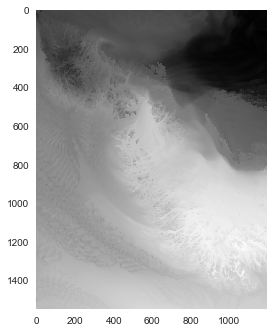

In [7]:
plt.imshow(fl_max)

### Extract regions


In [44]:
# Load region mask - only for data on 1km xgeo-grid
region_id = 3031
region_mask, y_min, y_max, x_min, x_max = load_region(region_id)
print(y_max-y_min, x_max-x_min)

Missing value: -32768
110 117


[ 1. nan nan ... nan nan nan]


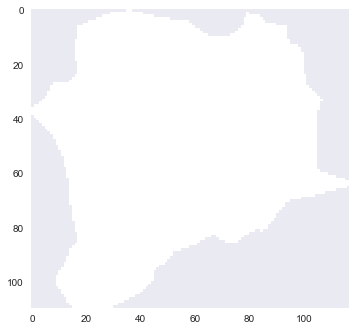

In [45]:
print(np.unique(region_mask))
plt.imshow(region_mask)

In [46]:
var_name = 'altitude_of_isoTprimW_equal_0'

for t in range(len(times)):
    t2 = t+hour_range[0]
    t_str = times[t]
    _fl = clip_region(np.flipud(nc_vars[var_name][t,:,:]), region_mask, t2, y_min, y_max, x_min, x_max)
    plt.imshow(_fl, vmin=0, vmax=500, cmap='magma')
    plt.axis('off')
    plt.text(5, 5, "{0}: {1}".format(region_id, t_str), bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(var_name)
    _png = './img/fl_{1:02}.png'.format(region_id, t)
    plt.savefig(_png, bbox_inches='tight')
    plt.clf()

<Figure size 576x396 with 0 Axes>

Use _make_gif.py_ in folder _img_ to generate a gif animation.

In [47]:
t_index = 0
fl_region = clip_region(np.flipud(fl_max), region_mask, t_index, y_min, y_max, x_min, x_max)
#print(np.unique(fl_3034))

4912
[123.6340332 126.0090332 140.1340332 ...         nan         nan
         nan]


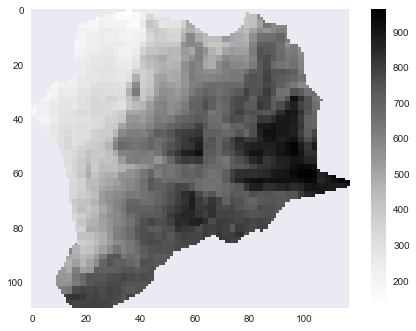

In [48]:
#fl_3034.masked_where(fl_region<=0.0)
print(np.count_nonzero(np.isnan(fl_region)))
print(np.unique(fl_region))
plt.imshow(fl_region)
plt.colorbar()

In [49]:
print("Mean\t: ", np.nanmean(fl_region.flatten()))
for p in [0,5,25,50,75, 80, 85,90, 95,100]:
    print(p, "\t: ", np.nanpercentile(fl_region.flatten(), p))

Mean	:  601.9236642396999
0 	:  123.634033203125
5 	:  242.259033203125
25 	:  442.134033203125
50 	:  649.134033203125
75 	:  757.009033203125
80 	:  778.384033203125
85 	:  795.009033203125
90 	:  832.134033203125
95 	:  879.884033203125
100 	:  964.009033203125


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


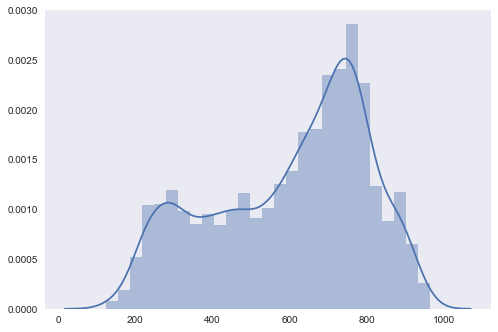

In [50]:
fl_region_flat = fl_region[~np.isnan(fl_region)].data.flatten()
sns.distplot(fl_region_flat)

## Calculating freezing level with regard to precipitation

In [51]:
nc_file2 = r"\\hdata\grid\metdata\prognosis\meps\det\archive\2019\meps_det_pp_1km_20190307T00Z.nc"
times, altitude, land_area_fraction, nc_vars2 = ga.nc_load(nc_file2, ["precipitation_amount"], time_period=hour_range)

### DIMENSIONS ###
OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 67
), ('height0', <class 'netCDF4._netCDF4.Dimension'>: name = 'height0', size = 1
), ('height1', <class 'netCDF4._netCDF4.Dimension'>: name = 'height1', size = 1
), ('height_above_msl', <class 'netCDF4._netCDF4.Dimension'>: name = 'height_above_msl', size = 1
), ('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1195
), ('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1550
)])
-	time
-	height0
-	height1
-	height_above_msl
-	x
-	y
### VARIABLES ###
-	time
-	forecast_reference_time
-	height_above_msl
-	height0
-	height1
-	x
-	y
-	relative_humidity_2m
-	air_pressure_at_sea_level
-	precipitation_amount_acc
-	precipitation_amount
-	cloud_area_fraction
-	wind_speed_of_gust
-	x_wind_10m
-	y_wind_10m
-	air_temperature_2m
-	altitude
-	projection_utm
-	lon
-	lat
Variable 'land_area_fraction' is not provided.


In [58]:
precip_sum = np.sum(nc_vars2['precipitation_amount'][0:6,:,:], axis=0)

In [61]:
t_index = 0
precip_sum_region = clip_region(np.flipud(precip_sum), region_mask, t_index, y_min, y_max, x_min, x_max)

4912
[0.359375   0.40917969 0.41796875 ...        nan        nan        nan]


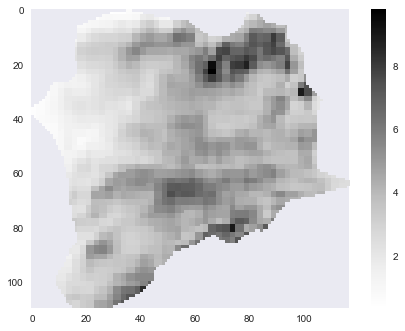

In [62]:
print(np.count_nonzero(np.isnan(precip_sum_region)))
print(np.unique(precip_sum_region))
plt.imshow(precip_sum_region)
plt.colorbar()

In [65]:
# Mask where the precipitation during the day exceeds a given value.
psr_mask = np.where(precip_sum_region >= 5., 1, np.nan)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


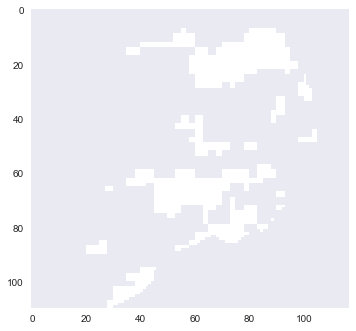

In [66]:
plt.imshow(psr_mask)

In [67]:
fl_region_wet = fl_region * psr_mask
print("Mean\t: ", np.nanmean(fl_region_wet.flatten()))
for p in [0,5,25,50,75, 80, 85,90, 95,100]:
    print(p, "\t: ", np.nanpercentile(fl_region_wet.flatten(), p))

Mean	:  686.2511252986575
0 	:  212.009033203125
5 	:  463.384033203125
25 	:  615.134033203125
50 	:  711.009033203125
75 	:  778.884033203125
80 	:  785.134033203125
85 	:  801.384033203125
90 	:  822.009033203125
95 	:  841.884033203125
100 	:  921.134033203125
